<a href="https://colab.research.google.com/github/naratiz/Precoce-MS/blob/main/Otimiza%C3%A7%C3%A3o_Classifica%C3%A7%C3%A3o_RFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install optuna
#!pip install plotly

import pandas as pd
import optuna
import time
import concurrent.futures
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR, LinearSVR  
from sklearn.metrics import classification_report,confusion_matrix

# Base de dados

In [ ]:
df = pd.read_csv('dados/procucao_gado_MS.csv', sep=';')

In [ ]:
print('A base de dados apresenta {} registros e {} características.'.format(df.shape[0], df.shape[1]))

A base de dados apresenta 960939 registros e 53 características.


## Separando os recursos do atributo alvo

In [ ]:
SEED = 42
y = df['categoria']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X = df.drop(['categoria','peso','acabamento', 'maturidade', 'classificacao','ano'],axis=1)

## StandardScaler

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=SEED)

In [ ]:
pca_test = PCA(n_components=40)
pca_test.fit(X_train)

PCA(n_components=40)

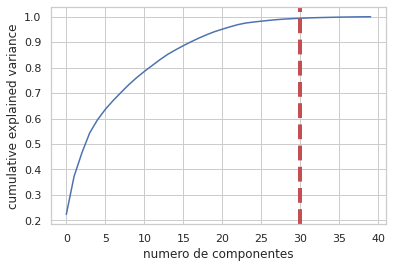

None

In [ ]:
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('numero de componentes')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=30, ymin=0, ymax=1)
display(plt.show())

In [ ]:
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(40))

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.223531,0.223531
1,0.373166,0.149635
2,0.465324,0.092158
3,0.543604,0.078280
4,0.595144,0.051540
5,0.636005,0.040861
6,0.670550,0.034544
7,0.702058,0.031508
8,0.732554,0.030496
9,0.760144,0.027590


In [ ]:
# Conforme o quadro acima, quando usamos o PCA para reduzir nossas 53 variáveis de previsão para 30 componentes,
# ainda podemos explicar mais de 99% da variação.  
# Usando essa lógica, usaremos o PCA para reduzir o número de componentes de 53 para 30 para X_train e X_test. 

In [ ]:
pca = PCA(n_components=30)
pca.fit(X_scaled)
X_scaled_pca = pca.transform(X_scaled)

## Baseline

In [ ]:
skfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

In [ ]:
rfc_baseline = RandomForestClassifier()
scores = cross_val_score(rfc_baseline, X_scaled_pca, y, cv=skfolds)

In [ ]:
scores.mean()

0.5161846922762237

## Otimização dos hiperparâmetros

Utilização do framework [Optuna](https://https://optuna.readthedocs.io/en/stable/) para otimização de hiperparâmetros

In [ ]:
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [ ]:
# função de otimização baseada em uma função objetivo
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=200)

    params = study.best_params
    print("\n")
    print(f"Melhor seleção de parâmetros : \n{params}")
    print("\n")
    print(f"Acurácia : {study.best_value:.3f}")

    return study, params

## Random Forest Classfier 


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_pca, y, test_size=0.3, random_state=SEED)

In [ ]:
def randomforestclassfier_objective(trial: optuna.Trial): 
    rfc_params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 300),
        "criterion" : trial.suggest_categorical("criterion", choices=["gini", "entropy"]),
        "max_depth":  trial.suggest_int("max_depth", 10, 200),
        "min_samples_split" : trial.suggest_int("min_samples_split", 5, 50),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", choices=["auto", "sqrt", "log2"]),
        "bootstrap": trial.suggest_categorical("bootstrap", choices=["True", "False"]),
        "random_state": SEED,
    }
    
    rfc = RandomForestClassifier(**rfc_params)
    scores = cross_val_score(rfc, X_train, y_train, n_jobs=-1, cv=skfolds)
    accuracy = scores.mean()
    return accuracy

In [ ]:
t0 = time.time()
study, rfc_params = tune(randomforestclassfier_objective)  
print("Pronto em:  %0.3f" %(time.time()-t0))

[I 2022-02-18 21:34:33,302] A new study created in memory with name: no-name-71d98d37-5d72-4e5b-97c3-3cc0bdbf7ce5
[I 2022-02-18 21:37:21,393] Trial 0 finished with value: 0.5100593626517976 and parameters: {'n_estimators': 68, 'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 35, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 0 with value: 0.5100593626517976.
[I 2022-02-18 21:39:35,703] Trial 1 finished with value: 0.513228882671032 and parameters: {'n_estimators': 60, 'criterion': 'entropy', 'max_depth': 164, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': 'False'}. Best is trial 1 with value: 0.513228882671032.
[I 2022-02-18 21:41:08,178] Trial 2 finished with value: 0.5128096499122067 and parameters: {'n_estimators': 41, 'criterion': 'gini', 'max_depth': 110, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 1 with value: 0.513228882671032.
[I 20

[I 2022-02-19 01:06:44,501] Trial 26 finished with value: 0.5138488109761984 and parameters: {'n_estimators': 276, 'criterion': 'entropy', 'max_depth': 185, 'min_samples_split': 45, 'min_samples_leaf': 7, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 24 with value: 0.5140301814258923.
[I 2022-02-19 01:14:10,106] Trial 27 finished with value: 0.5136808207953796 and parameters: {'n_estimators': 248, 'criterion': 'entropy', 'max_depth': 66, 'min_samples_split': 32, 'min_samples_leaf': 2, 'max_features': 'auto', 'bootstrap': 'False'}. Best is trial 24 with value: 0.5140301814258923.
[I 2022-02-19 01:19:09,391] Trial 28 finished with value: 0.5137848858636573 and parameters: {'n_estimators': 191, 'criterion': 'entropy', 'max_depth': 144, 'min_samples_split': 48, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'False'}. Best is trial 24 with value: 0.5140301814258923.
[I 2022-02-19 01:27:00,106] Trial 29 finished with value: 0.513829484907107 and parameters: {'n_est

[I 2022-02-19 04:21:02,986] Trial 53 finished with value: 0.5143334565104114 and parameters: {'n_estimators': 272, 'criterion': 'entropy', 'max_depth': 23, 'min_samples_split': 48, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'False'}. Best is trial 53 with value: 0.5143334565104114.
[I 2022-02-19 04:28:14,672] Trial 54 finished with value: 0.5146486255380698 and parameters: {'n_estimators': 234, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 48, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'False'}. Best is trial 54 with value: 0.5146486255380698.
[I 2022-02-19 04:36:47,199] Trial 55 finished with value: 0.5139290899925811 and parameters: {'n_estimators': 271, 'criterion': 'entropy', 'max_depth': 28, 'min_samples_split': 44, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'False'}. Best is trial 54 with value: 0.5146486255380698.
[I 2022-02-19 04:43:58,255] Trial 56 finished with value: 0.5146724123634999 and parameters: {'n_est

[I 2022-02-19 06:53:04,351] Trial 80 finished with value: 0.5134028192045922 and parameters: {'n_estimators': 159, 'criterion': 'gini', 'max_depth': 32, 'min_samples_split': 23, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': 'False'}. Best is trial 71 with value: 0.5147095784190581.
[I 2022-02-19 06:59:53,155] Trial 81 finished with value: 0.5146397061691899 and parameters: {'n_estimators': 235, 'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 32, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': 'False'}. Best is trial 71 with value: 0.5147095784190581.
[I 2022-02-19 07:06:47,361] Trial 82 finished with value: 0.514361703141837 and parameters: {'n_estimators': 227, 'criterion': 'gini', 'max_depth': 22, 'min_samples_split': 33, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': 'False'}. Best is trial 71 with value: 0.5147095784190581.
[I 2022-02-19 07:13:39,834] Trial 83 finished with value: 0.5141639798823012 and parameters: {'n_estimators': 

[I 2022-02-19 10:07:32,390] Trial 107 finished with value: 0.5137373132957463 and parameters: {'n_estimators': 266, 'criterion': 'gini', 'max_depth': 62, 'min_samples_split': 34, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': 'False'}. Best is trial 94 with value: 0.5147229577265394.
[I 2022-02-19 10:15:25,025] Trial 108 finished with value: 0.5137387997872397 and parameters: {'n_estimators': 252, 'criterion': 'gini', 'max_depth': 28, 'min_samples_split': 35, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': 'False'}. Best is trial 94 with value: 0.5147229577265394.
[I 2022-02-19 10:22:29,300] Trial 109 finished with value: 0.5146218665252889 and parameters: {'n_estimators': 237, 'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 32, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': 'False'}. Best is trial 94 with value: 0.5147229577265394.
[I 2022-02-19 10:27:42,886] Trial 110 finished with value: 0.49360075075725957 and parameters: {'n_estimat

[I 2022-02-19 13:10:53,306] Trial 134 finished with value: 0.5138815177119831 and parameters: {'n_estimators': 246, 'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 32, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': 'False'}. Best is trial 126 with value: 0.5147467446293231.
[I 2022-02-19 13:18:17,705] Trial 135 finished with value: 0.5138354318565754 and parameters: {'n_estimators': 241, 'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 36, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': 'False'}. Best is trial 126 with value: 0.5147467446293231.
[I 2022-02-19 13:25:10,194] Trial 136 finished with value: 0.5143899504694444 and parameters: {'n_estimators': 227, 'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 31, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': 'False'}. Best is trial 126 with value: 0.5147467446293231.
[I 2022-02-19 13:32:52,644] Trial 137 finished with value: 0.5143958958497417 and parameters: {'n_estim

[I 2022-02-19 16:01:58,862] Trial 161 finished with value: 0.5145430744534701 and parameters: {'n_estimators': 152, 'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 35, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': 'False'}. Best is trial 126 with value: 0.5147467446293231.
[I 2022-02-19 16:06:06,920] Trial 162 finished with value: 0.5138235388416785 and parameters: {'n_estimators': 161, 'criterion': 'gini', 'max_depth': 24, 'min_samples_split': 34, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': 'False'}. Best is trial 126 with value: 0.5147467446293231.
[I 2022-02-19 16:11:26,253] Trial 163 finished with value: 0.5143825169732298 and parameters: {'n_estimators': 177, 'criterion': 'gini', 'max_depth': 21, 'min_samples_split': 37, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': 'False'}. Best is trial 126 with value: 0.5147467446293231.
[I 2022-02-19 16:16:23,609] Trial 164 finished with value: 0.5078635926560964 and parameters: {'n_estim

[I 2022-02-19 18:55:25,662] Trial 188 finished with value: 0.5141327604004946 and parameters: {'n_estimators': 238, 'criterion': 'gini', 'max_depth': 24, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': 'False'}. Best is trial 126 with value: 0.5147467446293231.
[I 2022-02-19 19:03:02,502] Trial 189 finished with value: 0.5135068843391728 and parameters: {'n_estimators': 246, 'criterion': 'entropy', 'max_depth': 32, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 126 with value: 0.5147467446293231.
[I 2022-02-19 19:10:00,533] Trial 190 finished with value: 0.5145742935706101 and parameters: {'n_estimators': 230, 'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 29, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': 'False'}. Best is trial 126 with value: 0.5147467446293231.
[I 2022-02-19 19:16:58,765] Trial 191 finished with value: 0.5145891604856858 and parameters: {'n_est



Melhor seleção de parâmetros : 
{'n_estimators': 247, 'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 32, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': 'False'}


Acurácia : 0.515
Pronto em:  81335.443


In [ ]:
rfc_params

{'n_estimators': 247,
 'criterion': 'gini',
 'max_depth': 20,
 'min_samples_split': 32,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'bootstrap': 'False'}

## Analisando a importância de cada variável

In [ ]:
nomes_caracteristicas = []
for i in X.columns:
    nomes_caracteristicas.append(i)

In [ ]:
importancia = model_rfc.feature_importances_
# Importâncias de características são fornecidas pelo atributo ajustado feature_importances_ 
# e são calculadas como a média e o desvio padrão de acumulação da diminuição de impurezas dentro de cada árvore.
std = np.std([tree.feature_importances_ for tree in model_rfc.estimators_], axis=0)

In [ ]:
forest_importances = pd.Series(importancia, index=nomes_caracteristicas)
forest_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()